### In this code Iam trying to implement the stats+prediction+plotting in single code

C:\Users\Ayush_trainee\AppData\Local\Temp\ipykernel_13448\817872630.py:34: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  device_time = datetime.utcfromtimestamp(record["device_t"])
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.p

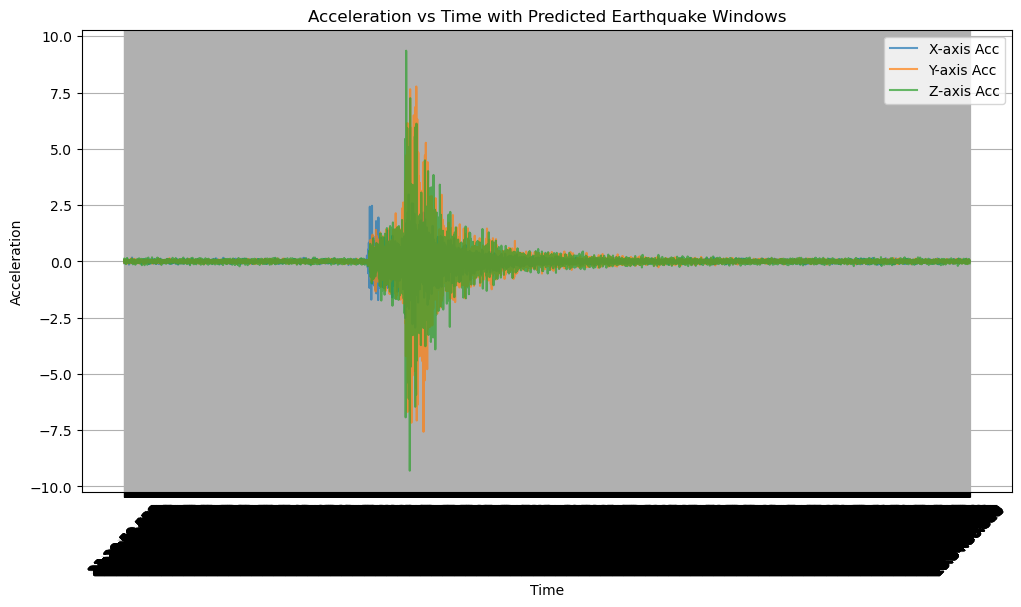

Processing complete! Results saved as CSV and plot.


In [19]:
import os
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, mode, zscore
from datetime import datetime, timedelta
from obspy.signal.trigger import classic_sta_lta

# Load the trained model and scaler
# Load the trained model and scaler
with open("sgd_classifier_model_standardscalar.pkl", "rb") as f:
    model = pickle.load(f)
with open("scaler_standardscalar.pkl", "rb") as f:
    scaler = pickle.load(f)

# Function to compute Modified Energy Ratio (MER)
def compute_mer(signal, window_size=50):
    if len(signal) < window_size:
        return np.zeros(len(signal))  # Handle short signals
    energy = np.convolve(signal**2, np.ones(window_size), mode='valid')
    mer = np.zeros(len(signal))
    mer[window_size - 1 : window_size - 1 + len(energy)] = energy
    return mer

# Load the JSONL file
json_file_path = "AWS EARTHQUAKE DATASET/date=2022-01-16 time=23-31-08/005/30.jsonl"
x_data, y_data, z_data, time_data = [], [], [], []

with open(json_file_path, "r") as file:
    for line in file:
        record = json.loads(line)
        device_time = datetime.utcfromtimestamp(record["device_t"])
        sr = record["sr"]
        duration = len(record["x"]) / sr
        
        time_values = [(device_time - timedelta(seconds=(duration - i / sr))).strftime('%H:%M:%S.%f')[:-3] 
                       for i in range(len(record["x"]))]
        
        x_data.extend(record["x"])
        y_data.extend(record["y"])
        z_data.extend(record["z"])
        time_data.extend(time_values)

# Convert to NumPy arrays
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)
time_data = np.array(time_data)

# Compute STA/LTA and MER
sta_window, lta_window = int(1 * sr), int(10 * sr)
sta_lta_x = classic_sta_lta(x_data, sta_window, lta_window) if len(x_data) >= lta_window else np.zeros(len(x_data))
mer_x = compute_mer(x_data, window_size=50)

# Sliding window parameters
step_size = int(0.5 * sr)  # Shift by 0.5 sec
window_size = int(1.5 * sr)  # 1.5 sec window

predictions, window_indices, window_times = [], [], []

for start in range(0, len(x_data) - window_size + 1, step_size):
    end = start + window_size
    before_data, after_data = x_data[start : start + int(1 * sr)], x_data[start + int(1 * sr) : end]
    before_sta_lta, after_sta_lta = sta_lta_x[start : start + int(1 * sr)], sta_lta_x[start + int(1 * sr) : end]
    before_mer, after_mer = mer_x[start : start + int(1 * sr)], mer_x[start + int(1 * sr) : end]
    
    # Compute statistical parameters
    def compute_stats(data, sta_lta, mer):
        if len(data) == 0:
            return [np.nan] * 13
        mode_value = mode(data, keepdims=True)[0]
        return [np.mean(data), np.median(data), mode_value[0] if mode_value.size > 0 else np.nan, np.std(data),
                skew(data), kurtosis(data), np.var(data), np.max(data), np.min(data),
                np.mean(zscore(data)), np.mean(sta_lta), np.max(sta_lta),
                np.mean(mer), np.max(mer)]
    
    before_stats, after_stats = compute_stats(before_data, before_sta_lta, before_mer), compute_stats(after_data, after_sta_lta, after_mer)
    stats_features = np.array(before_stats + after_stats).reshape(1, -1)
    stats_scaled = scaler.transform(stats_features)
    pred_label = model.predict(stats_scaled)[0]
    
    predictions.append(pred_label)
    window_indices.append(len(predictions))
    window_times.append(time_data[start])

# Convert to DataFrame and save results
df_results = pd.DataFrame({"Window": window_indices, "Start Time": window_times, "Prediction": predictions})
df_results.to_csv("prediction_results_14:18.csv", index=False)

# Plot acceleration data
plt.figure(figsize=(12, 6))
plt.plot(time_data, x_data, label="X-axis Acc", alpha=0.7)
plt.plot(time_data, y_data, label="Y-axis Acc", alpha=0.7)
plt.plot(time_data, z_data, label="Z-axis Acc", alpha=0.7)

# Highlight detected earthquake windows
for i, (window, t, pred) in enumerate(zip(window_indices, window_times, predictions)):
    if pred == 1:
        plt.axvline(x=t, color='r', linestyle='--', label=f"Window {window}" if i == 0 else "")
        plt.text(t, max(x_data), f"{window}", color='r', fontsize=10, rotation=90)

plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.title("Acceleration vs Time with Predicted Earthquake Windows")
plt.xticks(rotation=45)
plt.grid()
plt.savefig("acceleration_plot.png", dpi=300)
plt.show()

print("Processing complete! Results saved as CSV and plot.")


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, mode, zscore
from datetime import datetime, timedelta
from obspy.signal.trigger import classic_sta_lta

# Load the trained model and scaler
with open("sgd_classifier_model_standardscalar.pkl", "rb") as f:
    model = pickle.load(f)
with open("scaler_standardscalar.pkl", "rb") as f:
    scaler = pickle.load(f)

# Function to compute Modified Energy Ratio (MER)
def compute_mer(signal, window_size=50):
    if len(signal) < window_size:
        return np.zeros(len(signal))  # Handle short signals
    energy = np.convolve(signal**2, np.ones(window_size), mode='valid')
    mer = np.zeros(len(signal))
    mer[window_size - 1 : window_size - 1 + len(energy)] = energy
    return mer

# Function to compute statistics
def compute_stats(data, sta_lta, mer):
    if len(data) == 0:
        return [np.nan] * 14  # Return 14 NaNs if data is missing

    mode_value = mode(data, keepdims=True)[0]
    return [
        np.mean(data), np.median(data), mode_value[0] if mode_value.size > 0 else np.nan, np.std(data),
        skew(data), kurtosis(data), np.var(data), np.max(data), np.min(data),
        np.mean(zscore(data)), np.mean(sta_lta), np.max(sta_lta),
        np.mean(mer), np.max(mer)
    ]

# Load the JSONL file
json_file_path = "AWS EARTHQUAKE DATASET/date=2022-01-16 time=23-31-08/005/30.jsonl"  # Update with your file path
x_data, y_data, z_data, time_data = [], [], [], []

with open(json_file_path, "r") as file:
    for line in file:
        record = json.loads(line)
        device_time = datetime.utcfromtimestamp(record["device_t"])
        sr = record["sr"]
        duration = len(record["x"]) / sr
        
        time_values = [(device_time - timedelta(seconds=(duration - i / sr))).strftime('%H:%M:%S.%f')[:-3] 
                       for i in range(len(record["x"]))]

        x_data.extend(record["x"])
        y_data.extend(record["y"])
        z_data.extend(record["z"])
        time_data.extend(time_values)

# Convert to NumPy arrays
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)
time_data = np.array(time_data)


# Compute STA/LTA and MER
sta_window, lta_window = int(1 * sr), int(10 * sr)
sta_lta_x = classic_sta_lta(x_data, sta_window, lta_window) if len(x_data) >= lta_window else np.zeros(len(x_data))
mer_x = compute_mer(x_data, window_size=50)

# Sliding window parameters
step_size = int(0.5 * sr)  # Shift by 0.5 sec
window_size = int(1.5 * sr)  # 1.5 sec window

predictions, window_indices, window_times = [], [], []

for start in range(0, len(x_data) - window_size + 1, step_size):

    end = start + window_size
    before_data, after_data = x_data[start : start + int(1 * sr)], x_data[start + int(1 * sr) : end]
    before_sta_lta, after_sta_lta = 0,0
    before_mer, after_mer = mer_x[start : start + int(1 * sr)], mer_x[start + int(1 * sr) : end]

    before_stats = compute_stats(before_data, before_sta_lta, before_mer)
    after_stats = compute_stats(after_data, after_sta_lta, after_mer)
    stats_features = np.array(before_stats + after_stats).reshape(1, -1)  # Ensure 28 features

    stats_scaled = scaler.transform(stats_features)
    print(stats_scaled)
    pred_label = model.predict(stats_scaled)[0]
    print(pred_label)
    predictions.append(pred_label)
    window_indices.append(len(predictions))
    window_times.append(time_data[start])



# Convert to DataFrame and save results
df_results = pd.DataFrame({"Window": window_indices, "Start Time": window_times, "Prediction": predictions})
df_results.to_csv("prediction_14_34_results.csv", index=False)

# PLOTTING
plt.figure(figsize=(12, 6))
plt.plot(time_data, x_data, label="X-axis Acc", alpha=0.7)
plt.plot(time_data, y_data, label="Y-axis Acc", alpha=0.7)
plt.plot(time_data, z_data, label="Z-axis Acc", alpha=0.7)

# Highlight detected earthquake windows
for i, (window, t, pred) in enumerate(zip(window_indices, window_times, predictions)):
    if pred == 1:
        plt.axvline(x=t, color='r', linestyle='--', label="Detected Window" if i == 0 else "")
        plt.text(t, max(x_data), f"{window}", color='r', fontsize=8, rotation=90, verticalalignment='bottom')

# Reduce the number of x-axis labels
step = int(sr * 10)  # Show label every 10 seconds
plt.xticks(time_data[::step], rotation=45)

plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.title("Acceleration vs Time with Predicted Earthquake Windows")
plt.grid()
plt.savefig("acceleration_plot_11.png", dpi=300)
plt.show()

print("✅ Processing complete! Results saved as CSV and plot.")


C:\Users\Ayush_trainee\AppData\Local\Temp\ipykernel_13448\1538140691.py:46: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  device_time = datetime.utcfromtimestamp(record["device_t"])
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.

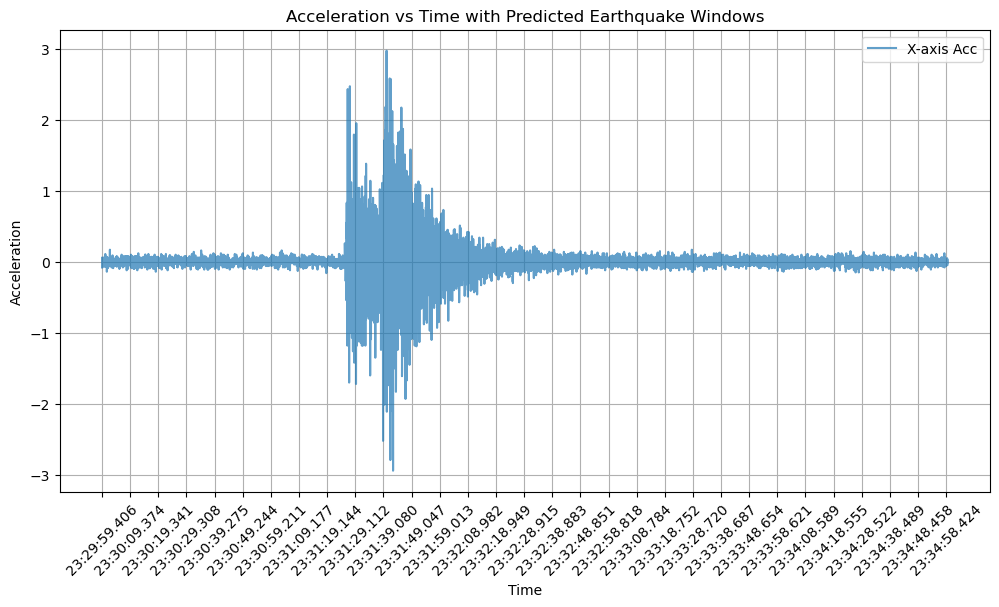

✅ Processing complete! Results saved as CSV and plot.


In [18]:
import os
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, mode, zscore
from datetime import datetime, timedelta
from obspy.signal.trigger import classic_sta_lta

# Load the trained model and scaler
with open("sgd_classifier_model_standardscalar.pkl", "rb") as f:
    model = pickle.load(f)
with open("scaler_standardscalar.pkl", "rb") as f:
    scaler = pickle.load(f)

# Function to compute Modified Energy Ratio (MER)
def compute_mer(signal, window_size=50):
    if len(signal) < window_size:
        return np.zeros(len(signal))  # Handle short signals
    energy = np.convolve(signal**2, np.ones(window_size), mode='valid')
    mer = np.zeros(len(signal))
    mer[window_size - 1 : window_size - 1 + len(energy)] = energy
    return mer

# Function to compute statistics
def compute_stats(data, sta_lta, mer):
    if len(data) == 0:
        return [np.nan] * 14  # Return 14 NaNs if data is missing

    mode_value = mode(data, keepdims=True)[0]
    return [
        np.mean(data), np.median(data), mode_value[0] if mode_value.size > 0 else np.nan, np.std(data),
        skew(data), kurtosis(data), np.var(data), np.max(data), np.min(data),
        np.mean(zscore(data)), np.mean(sta_lta), np.max(sta_lta),
        np.mean(mer), np.max(mer)
    ]

# Load the JSONL file
json_file_path = "AWS EARTHQUAKE DATASET/date=2022-01-16 time=23-31-08/005/30.jsonl"  # Update with your file path
x_data, y_data, z_data, time_data = [], [], [], []

with open(json_file_path, "r") as file:
    for line in file:
        record = json.loads(line)
        device_time = datetime.utcfromtimestamp(record["device_t"])
        sr = record["sr"]
        duration = len(record["x"]) / sr
        
        time_values = [(device_time - timedelta(seconds=(duration - i / sr))).strftime('%H:%M:%S.%f')[:-3] 
                       for i in range(len(record["x"]))]

        x_data.extend(record["x"])
        y_data.extend(record["y"])
        z_data.extend(record["z"])
        time_data.extend(time_values)

# Convert to NumPy arrays
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)
time_data = np.array(time_data)

# Compute STA/LTA and MER
sta_window, lta_window = int(1 * sr), int(10 * sr)
sta_lta_x = classic_sta_lta(x_data, sta_window, lta_window) if len(x_data) >= lta_window else np.zeros(len(x_data))
mer_x = compute_mer(x_data, window_size=50)

# Sliding window parameters
step_size = int(0.5 * sr)  # Shift by 0.5 sec
window_size = int(1.5 * sr)  # 1.5 sec window

predictions, window_indices, window_times = [], [], []

for start in range(0, len(x_data) - window_size + 1, step_size):
    end = start + window_size
    before_data, after_data = x_data[start : start + int(1 * sr)], x_data[start + int(1 * sr) : end]
    before_sta_lta, after_sta_lta = sta_lta_x[start : start + int(1 * sr)], sta_lta_x[start + int(1 * sr) : end]
    before_mer, after_mer = mer_x[start : start + int(1 * sr)], mer_x[start + int(1 * sr) : end]

    before_stats = compute_stats(before_data, before_sta_lta, before_mer)
    after_stats = compute_stats(after_data, after_sta_lta, after_mer)
    stats_features = np.array(before_stats + after_stats).reshape(1, -1)  # Ensure 28 features

    stats_scaled = scaler.transform(stats_features)
    pred_label = model.predict(stats_scaled)[0]

    predictions.append(pred_label)
    window_indices.append(len(predictions))
    window_times.append(time_data[start])

# Convert to DataFrame and save results
df_results = pd.DataFrame({"Window": window_indices, "Start Time": window_times, "Prediction": predictions})
df_results.to_csv("prediction_results_1111.csv", index=False)

# PLOTTING
plt.figure(figsize=(12, 6))
plt.plot(time_data, x_data, label="X-axis Acc", alpha=0.7)
# plt.plot(time_data, y_data, label="Y-axis Acc", alpha=0.7)
# plt.plot(time_data, z_data, label="Z-axis Acc", alpha=0.7)

# Highlight detected earthquake windows
for i, (window, t, pred) in enumerate(zip(window_indices, window_times, predictions)):
    if pred == 1:
        plt.axvline(x=t, color='r', linestyle='--', label="Detected Window" if i == 0 else "")
        plt.text(t, max(x_data), f"{window}", color='r', fontsize=8, rotation=90, verticalalignment='bottom')

# Reduce the number of x-axis labels
step = int(sr * 10)  # Show label every 10 seconds
plt.xticks(time_data[::step], rotation=45)

plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.title("Acceleration vs Time with Predicted Earthquake Windows")
plt.grid()
plt.savefig("222_acceleration_plot.png", dpi=300)
plt.show()

print("✅ Processing complete! Results saved as CSV and plot.")


C:\Users\Ayush_trainee\AppData\Local\Temp\ipykernel_13448\3179720327.py:46: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  device_time = datetime.utcfromtimestamp(record["device_t"])
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Ayush_trainee\anaconda3\Lib\site-packages\sklearn\base.

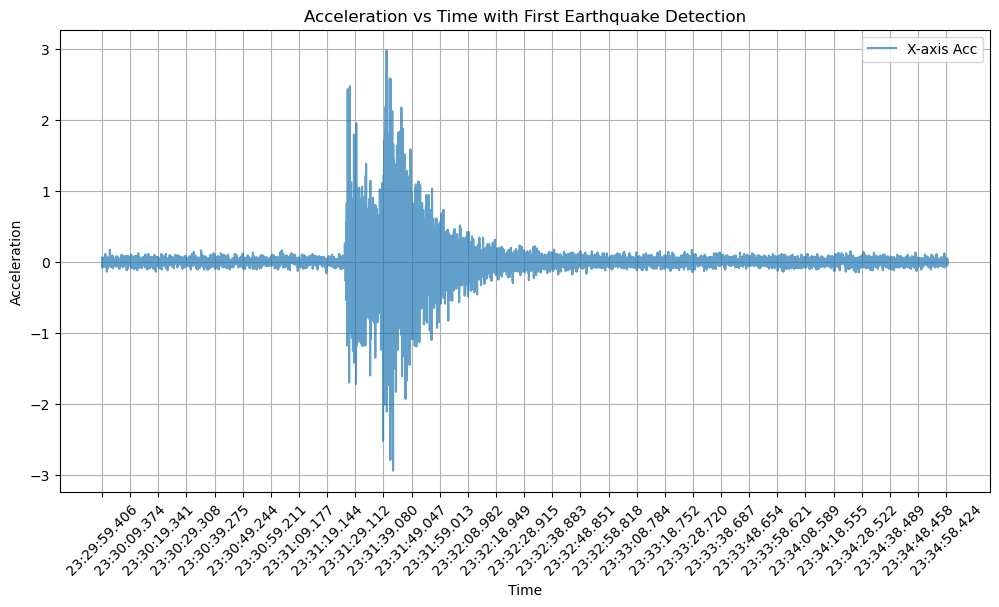

✅ Processing complete! First detection saved to CSV and plot.


In [20]:
import os
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, mode, zscore
from datetime import datetime, timedelta
from obspy.signal.trigger import classic_sta_lta

# Load the trained model and scaler
with open("sgd_classifier_model_standardscalar.pkl", "rb") as f:
    model = pickle.load(f)
with open("scaler_standardscalar.pkl", "rb") as f:
    scaler = pickle.load(f)

# Function to compute Modified Energy Ratio (MER)
def compute_mer(signal, window_size=50):
    if len(signal) < window_size:
        return np.zeros(len(signal))  # Handle short signals
    energy = np.convolve(signal**2, np.ones(window_size), mode='valid')
    mer = np.zeros(len(signal))
    mer[window_size - 1 : window_size - 1 + len(energy)] = energy
    return mer

# Function to compute statistics
def compute_stats(data, sta_lta, mer):
    if len(data) == 0:
        return [np.nan] * 14  # Return 14 NaNs if data is missing

    mode_value = mode(data, keepdims=True)[0]
    return [
        np.mean(data), np.median(data), mode_value[0] if mode_value.size > 0 else np.nan, np.std(data),
        skew(data), kurtosis(data), np.var(data), np.max(data), np.min(data),
        np.mean(zscore(data)), np.mean(sta_lta), np.max(sta_lta),
        np.mean(mer), np.max(mer)
    ]

# Load the JSONL file
json_file_path = "AWS EARTHQUAKE DATASET/date=2022-01-16 time=23-31-08/005/30.jsonl"  # Update with your file path
x_data, y_data, z_data, time_data = [], [], [], []

with open(json_file_path, "r") as file:
    for line in file:
        record = json.loads(line)
        device_time = datetime.utcfromtimestamp(record["device_t"])
        sr = record["sr"]
        duration = len(record["x"]) / sr
        
        time_values = [(device_time - timedelta(seconds=(duration - i / sr))).strftime('%H:%M:%S.%f')[:-3] 
                       for i in range(len(record["x"]))]

        x_data.extend(record["x"])
        y_data.extend(record["y"])
        z_data.extend(record["z"])
        time_data.extend(time_values)

# Convert to NumPy arrays
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)
time_data = np.array(time_data)

# Compute STA/LTA and MER
sta_window, lta_window = int(1 * sr), int(10 * sr)
sta_lta_x = classic_sta_lta(x_data, sta_window, lta_window) if len(x_data) >= lta_window else np.zeros(len(x_data))
mer_x = compute_mer(x_data, window_size=50)

# Sliding window parameters
step_size = int(0.5 * sr)  # Shift by 0.5 sec
window_size = int(1.5 * sr)  # 1.5 sec window

first_earthquake_time = None  # Store first earthquake detection time

for start in range(0, len(x_data) - window_size + 1, step_size):
    end = start + window_size
    before_data, after_data = x_data[start : start + int(1 * sr)], x_data[start + int(1 * sr) : end]
    before_sta_lta, after_sta_lta = sta_lta_x[start : start + int(1 * sr)], sta_lta_x[start + int(1 * sr) : end]
    before_mer, after_mer = mer_x[start : start + int(1 * sr)], mer_x[start + int(1 * sr) : end]

    before_stats = compute_stats(before_data, before_sta_lta, before_mer)
    after_stats = compute_stats(after_data, after_sta_lta, after_mer)
    stats_features = np.array(before_stats + after_stats).reshape(1, -1)  # Ensure 28 features

    stats_scaled = scaler.transform(stats_features)
    pred_label = model.predict(stats_scaled)[0]

    if pred_label == 1:  # If earthquake detected, store time and break
        first_earthquake_time = time_data[start]
        break  # Stop processing after first detection

# Convert to DataFrame and save results
df_results = pd.DataFrame({"Start Time": [first_earthquake_time] if first_earthquake_time else ["No earthquake detected"],
                           "Prediction": [1] if first_earthquake_time else [0]})
df_results.to_csv("prediction_results_single_detection.csv", index=False)

# PLOTTING
plt.figure(figsize=(12, 6))
plt.plot(time_data, x_data, label="X-axis Acc", alpha=0.7)

# Highlight first detected earthquake window
if first_earthquake_time:
    plt.axvline(x=first_earthquake_time, color='r', linestyle='--', label="First Detected Earthquake")
    plt.text(first_earthquake_time, max(x_data), "Earthquake Detected", color='r', fontsize=10, rotation=90, verticalalignment='bottom')

# Reduce the number of x-axis labels
step = int(sr * 10)  # Show label every 10 seconds
plt.xticks(time_data[::step], rotation=45)

plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.title("Acceleration vs Time with First Earthquake Detection")
plt.grid()
plt.savefig("single_detection_acceleration_plot.png", dpi=300)
plt.show()

print("✅ Processing complete! First detection saved to CSV and plot.")


C:\Users\Ayush_trainee\AppData\Local\Temp\ipykernel_13448\3050967352.py:53: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  device_time = datetime.utcfromtimestamp(record["device_t"])


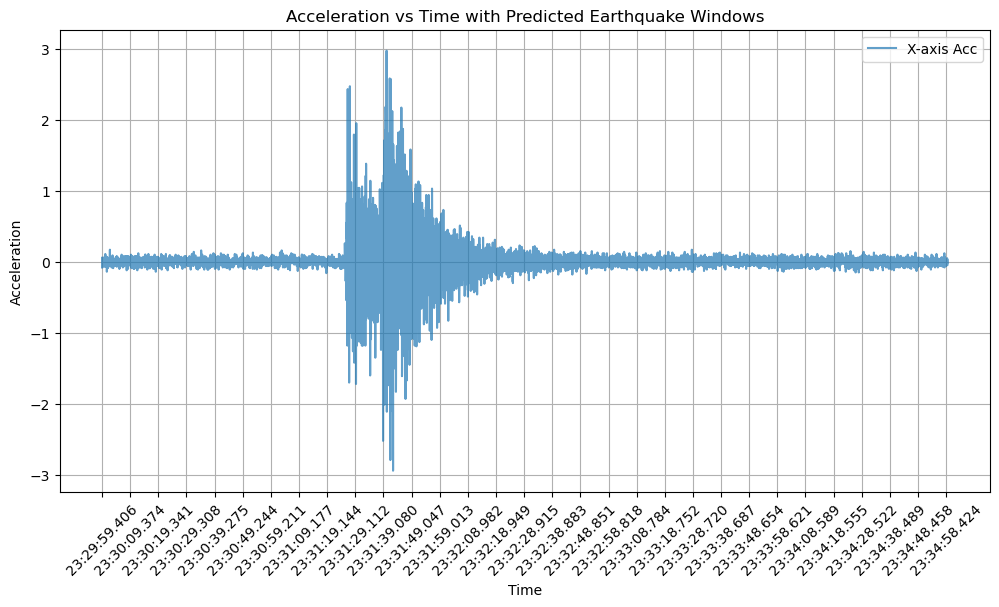

✅ Processing complete! Results saved as CSV and plot.


In [22]:
import os
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, mode, zscore
from datetime import datetime, timedelta
from obspy.signal.trigger import classic_sta_lta

# Load the trained model and scaler
model_path = "sgd_classifier_model_standardscalar.pkl"
scaler_path = "scaler_standardscalar.pkl"

# Load feature names
with open("feature_names_standardscalar.pkl", "rb") as f:
    feature_names = pickle.load(f)

with open(model_path, "rb") as f:
    model = pickle.load(f)
with open(scaler_path, "rb") as f:
    scaler = pickle.load(f)

# Function to compute Modified Energy Ratio (MER)
def compute_mer(signal, window_size=50):
    if len(signal) < window_size:
        return np.zeros(len(signal))  # Handle short signals
    energy = np.convolve(signal**2, np.ones(window_size), mode='valid')
    mer = np.zeros(len(signal))
    mer[window_size - 1 : window_size - 1 + len(energy)] = energy
    return mer

# Function to compute statistics
def compute_stats(data, sta_lta, mer):
    if len(data) == 0:
        return [np.nan] * 14  # Return 14 NaNs if data is missing

    mode_value = mode(data, keepdims=True)[0]
    return [
        np.mean(data), np.median(data), mode_value[0] if mode_value.size > 0 else np.nan, np.std(data),
        skew(data), kurtosis(data), np.var(data), np.max(data), np.min(data),
        np.mean(zscore(data)), np.mean(sta_lta), np.max(sta_lta),
        np.mean(mer), np.max(mer)
    ]

# Load the JSONL file
json_file_path = "AWS EARTHQUAKE DATASET/date=2022-01-16 time=23-31-08/005/30.jsonl"  # Update with your file path
x_data, y_data, z_data, time_data = [], [], [], []

with open(json_file_path, "r") as file:
    for line in file:
        record = json.loads(line)
        device_time = datetime.utcfromtimestamp(record["device_t"])
        sr = record["sr"]
        duration = len(record["x"]) / sr
        
        time_values = [(device_time - timedelta(seconds=(duration - i / sr))).strftime('%H:%M:%S.%f')[:-3] 
                       for i in range(len(record["x"]))]

        x_data.extend(record["x"])
        y_data.extend(record["y"])
        z_data.extend(record["z"])
        time_data.extend(time_values)

# Convert to NumPy arrays
x_data, y_data, z_data = np.array(x_data), np.array(y_data), np.array(z_data)
time_data = np.array(time_data)

# Compute STA/LTA and MER
sta_window, lta_window = int(1 * sr), int(10 * sr)
sta_lta_x = classic_sta_lta(x_data, sta_window, lta_window) if len(x_data) >= lta_window else np.zeros(len(x_data))
mer_x = compute_mer(x_data, window_size=50)

# Sliding window parameters
step_size = int(0.5 * sr)  # Shift by 0.5 sec
window_size = int(1.5 * sr)  # 1.5 sec window

predictions, window_indices, window_times = [], [], []
red_line_time = None  # Store the first occurrence of a predicted earthquake

for start in range(0, len(x_data) - window_size + 1, step_size):
    end = start + window_size
    before_data, after_data = x_data[start : start + int(1 * sr)], x_data[start + int(1 * sr) : end]
    before_sta_lta, after_sta_lta = sta_lta_x[start : start + int(1 * sr)], sta_lta_x[start + int(1 * sr) : end]
    before_mer, after_mer = mer_x[start : start + int(1 * sr)], mer_x[start + int(1 * sr) : end]

    before_stats = compute_stats(before_data, before_sta_lta, before_mer)
    after_stats = compute_stats(after_data, after_sta_lta, after_mer)

    # Convert to DataFrame with column names
    stats_features = pd.DataFrame([before_stats + after_stats], columns=feature_names)

    # Scale the features
    stats_scaled = scaler.transform(stats_features)
    pred_label = model.predict(stats_scaled)[0]

    predictions.append(pred_label)
    window_indices.append(len(predictions))
    window_times.append(time_data[start])

    # If an earthquake is detected, store the time and break
    if pred_label == 1:
        red_line_time = time_data[start]
        break

# Convert to DataFrame and save results
df_results = pd.DataFrame({"Window": window_indices, "Start Time": window_times, "Prediction": predictions})
df_results.to_csv("prediction_results_fixed.csv", index=False)

# PLOTTING
plt.figure(figsize=(12, 6))
plt.plot(time_data, x_data, label="X-axis Acc", alpha=0.7)

# Mark detected earthquake window
if red_line_time:
    plt.axvline(x=red_line_time, color='r', linestyle='--', label="Detected Earthquake Window")
    plt.text(red_line_time, max(x_data), "EQ Detected", color='r', fontsize=10, rotation=90, verticalalignment='bottom')

# Reduce the number of x-axis labels
step = int(sr * 10)  # Show label every 10 seconds
plt.xticks(time_data[::step], rotation=45)

plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.title("Acceleration vs Time with Predicted Earthquake Windows")
plt.grid()
plt.savefig("acceleration_plot_fixed.png", dpi=300)
plt.show()

print("✅ Processing complete! Results saved as CSV and plot.")
